In [4]:
import sys
sys.path.append("../")


In [5]:
import pandas as pd
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot
import numpy as np

from infrastructure.quotehistory_collection import quotehistoryCollection as qc
from simulation.ema_cross_multi_temporal_2_tester import EmaCrossMultiTemporal2Tester
from simulation.ema_cross_multi_temporal_3_tester import EmaCrossMultiTemporal3Tester
from simulation.ema_cross_multi_temporal_3_tester_fast import EmaCrossMultiTemporal3TesterFast

In [6]:


# Função para calcular a EMA
def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()



In [26]:

BUY = 1
SELL = -1
NONE = 0

def apply_signal_short1(row):
    if row.DELTA1 >= 0 and row.DELTA1_PREV < 0:
        return BUY
    elif row.DELTA1 < 0 and row.DELTA1_PREV >= 0:
        return SELL
    return NONE

def apply_signal_short2(row):
    if row.DELTA2 >= 0 and row.DELTA2_PREV < 0:
        return BUY
    elif row.DELTA2 < 0 and row.DELTA2_PREV >= 0:
        return SELL
    return NONE
    
def apply_signal1(row,spread=50):
    if row.SPREAD < spread and row.DELTA1 >= 0 and row.DELTA1_PREV < 0:
        return BUY
    elif row.SPREAD < spread and row.DELTA1 < 0 and row.DELTA1_PREV >= 0:
        return SELL
    return NONE

def apply_signal2(row,spread=50):
    if row.SPREAD < spread and (row.DELTA2 >= 0 and row.EMA_MID <= 1) and row.DELTA2_PREV < 0:
        return BUY
    elif row.SPREAD < spread and (row.DELTA2 < 0 and row.EMA_MID >= -1) and row.DELTA2_PREV >= 0:
        return SELL
    return NONE

def apply_signal4(row,spread=50):
    if row.SPREAD < spread and row.DIRECTION > 0 and row.DELTA1 >= 0 and row.DELTA1_PREV < 0:
        return BUY
    elif row.SPREAD < spread and row.DIRECTION < 0 and row.DELTA1 < 0 and row.DELTA1_PREV >= 0:
        return SELL
    return NONE
    

In [27]:
def run_pair(pair,pip_value,granularity='M5',use_spread=True,
             stop_loss = 1000, take_profit = 200, 
             fixed_tp_sl=True,trans_cost=8,
             neg_multiplier=1.5, rev=True,
             spread_limit=50,ema_1=0, ema_3=10000):
    df = pd.read_pickle(f"../data/{granularity}/{pair}_{granularity}.pkl")
    df.reset_index(drop=True, inplace=True)

    # ema_1 = 10
    ema_2 = 480
    # ema_3 = 10000
    df[f'EMA_{ema_1}'] = df.mid_c.ewm(span=ema_1, min_periods=ema_1).mean()
    df[f'EMA_{ema_2}'] = df.mid_c.ewm(span=ema_2, min_periods=ema_2).mean()
    df[f'EMA_{ema_3}'] = df.mid_c.ewm(span=ema_3, min_periods=ema_3).mean()
    df['DIRECTION'] = df[f'EMA_{ema_2}'] - df[f'EMA_{ema_3}']

    df['EMA_MID'] = df['mid_c'] - df[f'EMA_{ema_1}']
    
    df['DELTA1'] = df[f'EMA_{ema_1}'] - df[f'EMA_{ema_2}']
    df['DELTA1_PREV'] = df.DELTA1.shift(1)
    
    df['DELTA2'] = df[f'EMA_{ema_1}'] - df[f'EMA_{ema_3}']
    df['DELTA2_PREV'] = df.DELTA2.shift(1)
    
    df['donchian_high'] = df['mid_c'].rolling(window=400).max()
    df['donchian_low'] = df['mid_c'].rolling(window=400).min()
    df['donchian_mid'] = (df['donchian_high'] + df['donchian_low']) / 2
    df['DELTA3'] = df[f'EMA_{ema_1}'] - df[f'donchian_mid']
    df['DELTA3_PREV'] = df.DELTA3.shift(1)
    
    dev1 = 0.5
    dev2 = 1
    dev3 = 1.5
    df['SMA'] = df['mid_c'].rolling(window=50).mean()  # Média Móvel Simples (SMA)
    df[f'env_high1'] = df['SMA'] * (1 + dev1 / 100)
    df[f'env_low1'] = df['SMA'] * (1 - dev1 / 100)
    df[f'env_high2'] = df['SMA'] * (1 + dev2 / 100)
    df[f'env_low2'] = df['SMA'] * (1 - dev2 / 100)
    df[f'env_high3'] = df['SMA'] * (1 + dev3 / 100)
    df[f'env_low3'] = df['SMA'] * (1 - dev3 / 100)

    df['SPREAD'] = (df[f'ask_c'] - df[f'bid_c']) / pip_value
    df_slim = df.copy()
    df_slim.dropna(inplace=True)
    df_slim.reset_index(drop=True, inplace=True)

    gt = EmaCrossMultiTemporal3TesterFast(
        df_slim,
        apply_signal2,
        apply_signal_short2,
        pip_value,
        use_spread=use_spread,
        LOSS_FACTOR = stop_loss,
        PROFIT_FACTOR = take_profit,
        fixed_tp_sl=fixed_tp_sl,
        trans_cost=trans_cost,
        neg_multiplier=neg_multiplier,
        rev=rev,
        spread_limit=spread_limit
    )
    
    gt.run_test()
    return gt

In [28]:
pairs_pip_size = {
    # "EURGBP": 0.0001,
    # "EURJPY": 0.01,
    # "GBPJPY": 0.01,
    "GBPUSD": {
        "pip_value": 0.0001,  
        "spread": 15,       
        "trans_cost": 1
    },
    "USDJPY": {
        "pip_value": 0.01,  
        "spread": 10,       
        "trans_cost": 1
    },
    "EURUSD": {
        "pip_value": 0.0001,  
        "spread": 15,       
        "trans_cost": 1
    },
    "XAUUSD": { 
        "pip_value": 0.01,  
        "spread": 50,       
        "trans_cost": 10
    },
    # "ETHUSD": { 
    #     "pip_value": 0.01,  
    #     "spread": 50,       
    #     "trans_cost": 600
    # },
    # "ETHEUR": { 
    #     "pip_value": 0.01, 
    #     "spread": 50,       
    #     "trans_cost": 600
    # },
    # "ETHJPY":{ 
    #     "pip_value": 0.01,
    #     "spread": 50000,     
    #     "trans_cost": 84000
    # },
    # "ETHBTC":{ 
    #     "pip_value": 0.0001,
    #     "spread": 10,   
    #     "trans_cost": 2
    # },
    # "BTCEUR": { 
    #     "pip_value": 0.01,  
    #     "spread": 500,       
    #     "trans_cost": 28000
    # },
    # "BTCGBP": { 
    #     "pip_value": 0.01,
    #     "spread": 500,     
    #     "trans_cost": 20000
    # },
    # # "BTCJPY":{ 
    # #     "pip_value": 0.01,
    # #     "spread": 50000,     
    # #     "trans_cost": 4000000
    # # },
    # "BTCUSD":{ 
    #     "pip_value": 0.01,
    #     "spread": 500,       
    #     "trans_cost": 28000
    # },
    
    

}


pairs_pip_size = {
    "XAUUSD": { 
        "pip_value": 0.01,  
        "spread": 50,       
        "trans_cost": 10
    },
    # "XAUUSD2": { 
    #     "pip_value": 0.01,  
    #     "spread": 50,       
    #     "trans_cost": 10
    # },
    # "XAUUSD3": { 
    #     "pip_value": 0.01,  
    #     "spread": 50,       
    #     "trans_cost": 10
    # }
}

In [29]:

qc.LoadQuotehistory("../data")

SL = [500000]
TP = [500000]
neg_multiplier = 1
rev=False

res = []
for pair in pairs_pip_size:
    # if pair in qc.quotehistory_dict.keys():
    for es in [500]:
        for el in [10000]:
            print(f" Ema short: {es}  Ema Long {el}  Pair ---------> {pair}")
            pip_size = pairs_pip_size[pair]['pip_value']
            for sl in SL:
                for tp in TP:
                    print(f"SL => {sl} | TP => {tp}")
                    res.append(
                        dict(
                            pair=pair,
                            stop_loss=sl,
                            take_profit=tp,
                            res=run_pair(
                                pair,
                                pip_size,
                                granularity='M1',
                                use_spread=True,
                                stop_loss=sl,
                                take_profit=tp,
                                fixed_tp_sl=True,
                                trans_cost=pairs_pip_size[pair]['trans_cost'],
                                neg_multiplier=neg_multiplier,
                                rev=rev,
                                spread_limit=pairs_pip_size[pair]['spread'],
                                ema_1=es,
                                ema_3=el
                            )
                        )
                    )
                

 Ema short: 500  Ema Long 10000  Pair ---------> XAUUSD
SL => 500000 | TP => 500000
prepare_data...
run_test...
Result: -237.99999999999727
Len loss:  1
Len Open: 0
Len Close: 5


In [13]:

df = res[0]['res'].df
df.columns

Index(['time', 'bid_o', 'bid_h', 'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l',
       'ask_c', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'EMA_500', 'EMA_480',
       'EMA_10000', 'DIRECTION', 'EMA_MID', 'DELTA1', 'DELTA1_PREV', 'DELTA2',
       'DELTA2_PREV', 'donchian_high', 'donchian_low', 'donchian_mid',
       'DELTA3', 'DELTA3_PREV', 'SMA', 'env_high1', 'env_low1', 'env_high2',
       'env_low2', 'env_high3', 'env_low3', 'SPREAD', 'SIGNAL', 'SIGNAL_SHORT',
       'TP', 'SL', 'SL_VALUE'],
      dtype='object')

In [14]:
for r in res:
    print(r['pair'], r['res'].df_results.result.sum())

XAUUSD 27369.999999999985


In [25]:
df[['donchian_high', 'donchian_low', 'donchian_mid','env_high1', 'SPREAD', 'SIGNAL', 'EMA_MID']].describe()

,donchian_high,donchian_low,donchian_mid,env_high1,SPREAD,SIGNAL,EMA_MID
count,606400.000000,606400.000000,606400.000000,606400.000000,606400.000000,606400.000000,606400.000000
mean,2104.386979,2091.352977,2097.869978,2108.587627,21.161502,0.000000,0.318313
std,215.352192,212.687607,213.979678,215.319784,8.992615,0.014415,5.438117
min,1813.215000,1806.760000,1809.987500,1817.515465,-361.000000,-1.000000,-51.958705
25%,1941.935000,1932.660000,1937.410000,1946.726532,16.000000,0.000000,-2.112346
50%,2018.630000,2006.275000,2013.127500,2023.769002,21.000000,0.000000,0.272240
75%,2328.250000,2311.270000,2319.947500,2331.751855,25.000000,0.000000,2.691957
max,2685.640000,2669.355000,2673.510000,2694.846798,437.000000,1.000000,66.513985


In [16]:
df_results = res[0]['res'].df_results
pair = res[0]['pair']
print(pair)
print(df_results.columns)
res_pos = df_results[df_results['result'] > 0]
res_neg = df_results[df_results['result'] < 0]
df_results.shape, res_pos.shape, res_neg.shape

XAUUSD
Index(['running', 'start_index_m5', 'profit_factor', 'loss_factor',
       'pip_value', 'SL_value', 'count', 'neg_multiplier', 'trans_cost',
       'trigger_type', 'rev', 'start_price', 'trigger_price', 'SIGNAL', 'TP',
       'SL', 'result', 'end_time', 'start_time'],
      dtype='object')


((126, 19), (65, 19), (61, 19))

In [17]:
df_results.describe()

,start_index_m5,profit_factor,loss_factor,pip_value,SL_value,count,neg_multiplier,trans_cost,trigger_type,start_price,SIGNAL,TP,SL,result,end_time,start_time
count,126.000000,126.0,126.0,126.00,126.0,126.000000,126.0,126.0,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126,126
mean,290267.182540,500000.0,500000.0,0.01,500000.0,1525.373016,1.0,10.0,3.515873,2090.251508,0.000000,2090.254762,2090.254762,217.222222,2023-11-09 13:26:41.428571648,2023-11-07 23:42:43.333333248
min,15244.000000,500000.0,500000.0,0.01,500000.0,3.000000,1.0,10.0,3.000000,1822.090000,-1.000000,-3178.080000,-3169.350000,-3504.000000,2023-01-27 09:31:00,2023-01-27 08:23:00
25%,140992.250000,500000.0,500000.0,0.01,500000.0,232.500000,1.0,10.0,3.000000,1955.667500,-1.000000,-2987.167500,-2989.415000,-819.000000,2023-06-07 15:39:00,2023-06-06 17:49:15
50%,293641.500000,500000.0,500000.0,0.01,500000.0,522.000000,1.0,10.0,4.000000,2010.645000,0.000000,2167.040000,2166.815000,121.000000,2023-11-12 15:43:30,2023-11-10 18:52:30
75%,455252.750000,500000.0,500000.0,0.01,500000.0,1522.250000,1.0,10.0,4.000000,2319.322500,1.000000,7008.627500,7010.772500,911.750000,2024-04-28 11:21:45,2024-04-26 14:51:45
max,587150.000000,500000.0,500000.0,0.01,500000.0,25104.000000,1.0,10.0,4.000000,2511.530000,1.000000,7511.710000,7503.430000,12357.000000,2024-09-11 01:34:00,2024-09-09 22:53:00
std,174373.289948,0.0,0.0,0.00,0.0,3096.763308,0.0,0.0,0.501743,188.960557,1.003992,5024.219332,5022.811553,1863.170201,NaN,NaN


In [18]:
df_results['SIGNAL'].value_counts()

SIGNAL
-1    63
 1    63
Name: count, dtype: int64

In [19]:
df_results.result.sum()

np.float64(27369.999999999985)

In [20]:
sum_neg = res_neg.result.sum()
sum_neg, sum_neg/res_neg.shape[0]

(np.float64(-60139.000000000065), np.float64(-985.8852459016405))

In [21]:
sum_pos = res_pos.result.sum()
sum_pos, sum_pos/res_pos.shape[0]

(np.float64(87509.00000000006), np.float64(1346.2923076923087))

In [22]:
res_neg.describe()

,start_index_m5,profit_factor,loss_factor,pip_value,SL_value,count,neg_multiplier,trans_cost,trigger_type,start_price,SIGNAL,TP,SL,result,end_time,start_time
count,61.000000,61.0,61.0,6.100000e+01,61.0,61.000000,61.0,61.0,61.0,61.000000,61.000000,61.000000,61.000000,61.000000,61,61
mean,284862.311475,500000.0,500000.0,1.000000e-02,500000.0,1460.950820,1.0,10.0,4.0,2085.630984,0.016393,2167.611639,2003.677213,-985.885246,2023-11-03 22:28:29.508196864,2023-11-02 09:07:20.655737856
min,15244.000000,500000.0,500000.0,1.000000e-02,500000.0,3.000000,1.0,10.0,4.0,1830.510000,-1.000000,-3084.030000,-3169.350000,-3504.000000,2023-01-27 09:31:00,2023-01-27 08:23:00
25%,140575.000000,500000.0,500000.0,1.000000e-02,500000.0,361.000000,1.0,10.0,4.0,1958.080000,-1.000000,-3012.060000,-2967.880000,-1310.000000,2023-06-07 15:26:00,2023-06-06 10:37:00
50%,247810.000000,500000.0,500000.0,1.000000e-02,500000.0,622.000000,1.0,10.0,4.0,2006.300000,1.000000,6830.650000,-2593.930000,-846.000000,2023-09-25 00:34:00,2023-09-22 13:11:00
75%,422442.000000,500000.0,500000.0,1.000000e-02,500000.0,1916.000000,1.0,10.0,4.0,2162.490000,1.000000,7032.120000,6985.900000,-502.000000,2024-03-25 01:50:00,2024-03-22 18:36:00
max,585573.000000,500000.0,500000.0,1.000000e-02,500000.0,6209.000000,1.0,10.0,4.0,2503.610000,1.000000,7406.070000,7503.430000,-106.000000,2024-09-09 22:53:00,2024-09-06 18:34:00
std,172217.569927,0.0,0.0,1.749120e-18,0.0,1677.673413,0.0,0.0,0.0,182.533408,1.008163,5042.799380,5045.441877,675.650652,NaN,NaN


In [23]:
res_pos.describe()


,start_index_m5,profit_factor,loss_factor,pip_value,SL_value,count,neg_multiplier,trans_cost,trigger_type,start_price,SIGNAL,TP,SL,result,end_time,start_time
count,65.000000,65.0,65.0,65.00,65.0,65.000000,65.0,65.0,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65,65
mean,295339.446154,500000.0,500000.0,0.01,500000.0,1585.830769,1.0,10.0,3.061538,2094.587692,-0.015385,2017.658308,2171.504462,1346.292308,2023-11-14 20:06:32.307692288,2023-11-13 06:01:09.230769152
min,15312.000000,500000.0,500000.0,0.01,500000.0,5.000000,1.0,10.0,3.000000,1822.090000,-1.000000,-3178.080000,-3168.190000,46.000000,2023-01-27 13:21:00,2023-01-27 09:31:00
25%,142244.000000,500000.0,500000.0,0.01,500000.0,148.000000,1.0,10.0,3.000000,1954.360000,-1.000000,-2975.920000,-2990.710000,502.000000,2023-06-07 16:18:00,2023-06-07 15:26:00
50%,297700.000000,500000.0,500000.0,0.01,500000.0,438.000000,1.0,10.0,3.000000,2014.310000,-1.000000,-2598.340000,6821.920000,869.000000,2023-11-16 16:04:00,2023-11-14 17:35:00
75%,456910.000000,500000.0,500000.0,0.01,500000.0,979.000000,1.0,10.0,3.000000,2322.340000,1.000000,6997.430000,7024.080000,1366.000000,2024-04-30 04:26:00,2024-04-29 19:30:00
max,587150.000000,500000.0,500000.0,0.01,500000.0,25104.000000,1.0,10.0,4.000000,2511.530000,1.000000,7511.710000,7401.660000,12357.000000,2024-09-11 01:34:00,2024-09-09 22:53:00
std,177560.190768,0.0,0.0,0.00,0.0,4010.487893,0.0,0.0,0.242186,196.119796,1.007663,5044.877284,5039.382602,1917.752988,NaN,NaN


In [24]:

cp = CandlePlot(df.iloc[0:10000])

trades = cp.df_plot[cp.df_plot.SIGNAL != NONE]


# trades

markers = ['bid_c', 'bid_c', 'bid_c']
marker_colors = ['#0000FF', '#00FF00', '#FF0000']

cp.fig.add_trace(go.Scatter(
    x = trades.sTime,
    y = trades[markers[0]],
    mode = 'markers',
    marker=dict(color=marker_colors[0], size=12)
))

cp.show_plot(line_traces=["EMA_500","EMA_5000"], height=500)

KeyError: 'EMA_5000'

In [58]:
# cp = CandlePlot(df.iloc[10000:20000])
# cp.show_plot(line_traces=['EMA_3','EMA_480','env_high1','env_low1','env_high2','env_low2'])

In [59]:
# ema_1 = 10
# ema_2 = 30
# df_4h = pd.read_pickle(f"../data/H4/{pair}_H4.pkl")
# df_4h[f'EMA_{ema_1}'] = df_4h.mid_c.ewm(span=ema_1, min_periods=ema_1).mean()
# df_4h[f'EMA_{ema_2}'] = df_4h.mid_c.ewm(span=ema_2, min_periods=ema_2).mean()

In [60]:
# cp = CandlePlot(df_4h.iloc[400:700])
# cp.show_plot(line_traces=['EMA_10','EMA_30'])

In [61]:
df_results['time'] = df_results['end_time']

In [62]:
df_results['GAIN_C'] = df_results.result.cumsum()

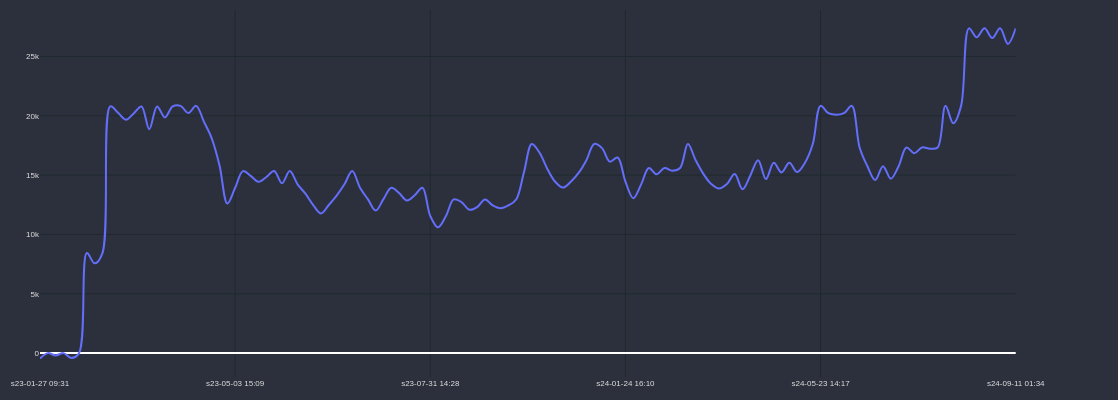

In [63]:
cp = CandlePlot(df_results, candles=False)
cp.show_plot(line_traces = ['GAIN_C'])

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def gerar_relatorios(df):
    # Configurações gerais para gráficos
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # 1. Análise de Desempenho por Tipo de Fechamento (Trigger Type)
    print("Relatório de Desempenho por Tipo de Fechamento")
    trigger_counts = df['trigger_type'].value_counts()
    print(trigger_counts)
    
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='trigger_type')
    plt.title("Frequência de Operações por Trigger Type")
    plt.show()

    # 2. Análise de Rentabilidade por Compra e Venda (Signal)
    print("\nRelatório de Rentabilidade por Compra e Venda (Signal)")
    signal_profit = df.groupby('SIGNAL')['result'].mean()
    print(signal_profit)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=signal_profit.index, y=signal_profit.values)
    plt.title("Rentabilidade Média por Compra e Venda")
    plt.show()

    # 3. Análise de Resultados por Período (start_time, end_time)
    print("\nAnálise de Resultados por Período")
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
    result_over_time = df.groupby(df['start_time'].dt.date)['result'].sum()
    print(result_over_time)
    
    plt.figure(figsize=(10, 6))
    result_over_time.plot()
    plt.title("Resultados ao Longo do Tempo")
    plt.show()

    # 4. Eficiência Operacional: Diferença entre Preço de Entrada e Saída
    print("\nDiferença entre Preço de Entrada e Saída (Eficiência Operacional)")
    df['price_difference'] = df['trigger_price'] - df['start_price']
    price_diff_mean = df['price_difference'].mean()
    print(f"Média da diferença de preço: {price_diff_mean} pips")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price_difference'], bins=30, kde=True)
    plt.title("Distribuição da Diferença de Preço (Start vs Trigger)")
    plt.show()

    # 5. Volatilidade e Duração das Operações (Contagem de Candles)
    print("\nAnálise de Volatilidade e Duração das Operações (Contagem de Candles)")
    count_result_corr = df[['count', 'result']].corr()
    print(f"Correlação entre duração (candles) e resultado: {count_result_corr.iloc[0, 1]}")
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='count', y='result', hue='trigger_type', palette='viridis')
    plt.title("Relação entre Duração da Operação e Resultado")
    plt.show()

    # 6. Análise de Perdas Acumuladas (Trigger Type 3)
    print("\nAnálise de Perdas Acumuladas (Trigger Type 3)")
    acum_loss_df = df[df['trigger_type'] == 3]
    if not acum_loss_df.empty:
        acum_loss_mean = acum_loss_df['result'].mean()
        print(f"Média de pips recuperados em perdas acumuladas: {acum_loss_mean}")
        plt.figure(figsize=(10, 6))
        sns.histplot(acum_loss_df['result'], bins=30, kde=True)
        plt.title("Distribuição de Recuperação de Perdas Acumuladas (2x Perda)")
        plt.show()
    else:
        print("Nenhuma operação encerrada por Perda Acumulada")

    # 7. Eficiência do Cruzamento Reverso (Trigger Type 4)
    print("\nEficiência do Cruzamento Reverso (Trigger Type 4)")
    reversed_cross_df = df[df['trigger_type'] == 4]
    if not reversed_cross_df.empty:
        rev_cross_mean = reversed_cross_df['result'].mean()
        print(f"Resultado médio de cruzamento reverso: {rev_cross_mean}")
        plt.figure(figsize=(10, 6))
        sns.histplot(reversed_cross_df['result'], bins=30, kde=True)
        plt.title("Distribuição de Resultados - Cruzamento Reverso")
        plt.show()
    else:
        print("Nenhuma operação encerrada por Cruzamento Reverso")

    # 8. Análise de Take Profit (Trigger Type 1) e Stop Loss (Trigger Type 2)
    print("\nAnálise de Take Profit (Trigger Type 1) e Stop Loss (Trigger Type 2)")
    tp_df = df[df['trigger_type'] == 1]
    sl_df = df[df['trigger_type'] == 2]
    
    print(f"Take Profit médio: {tp_df['result'].mean()}")
    print(f"Stop Loss médio: {sl_df['result'].mean()}")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(tp_df['result'], bins=30, kde=True, color='green', label='Take Profit')
    sns.histplot(sl_df['result'], bins=30, kde=True, color='red', label='Stop Loss')
    plt.legend()
    plt.title("Distribuição de Resultados - Take Profit vs Stop Loss")
    plt.show()

    # 9. Análise de Drawdown e Recuperação
    print("\nAnálise de Drawdown e Recuperação")
    df['accumulated_pips'] = df['result'].cumsum()
    plt.figure(figsize=(10, 6))
    plt.plot(df['start_time'], df['accumulated_pips'])
    plt.title("Acumulação de Pips ao Longo do Tempo (Drawdown e Recuperação)")
    plt.show()

    # 10. Eficiência Temporal e Tendências
    print("\nAnálise de Eficiência Temporal e Tendências")
    df['hour'] = df['start_time'].dt.hour
    hourly_result = df.groupby('hour')['result'].mean()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=hourly_result.index, y=hourly_result.values)
    plt.title("Rentabilidade Média por Horário")
    plt.show()

# Exemplo de uso:
# df = pd.read_csv('seu_arquivo.csv')  # Supondo que você já tem o dataframe pronto
# gerar_relatorios(df)


Relatório de Desempenho por Tipo de Fechamento
trigger_type
4    546
3    469
Name: count, dtype: int64


<Figure size 1000x600 with 0 Axes>

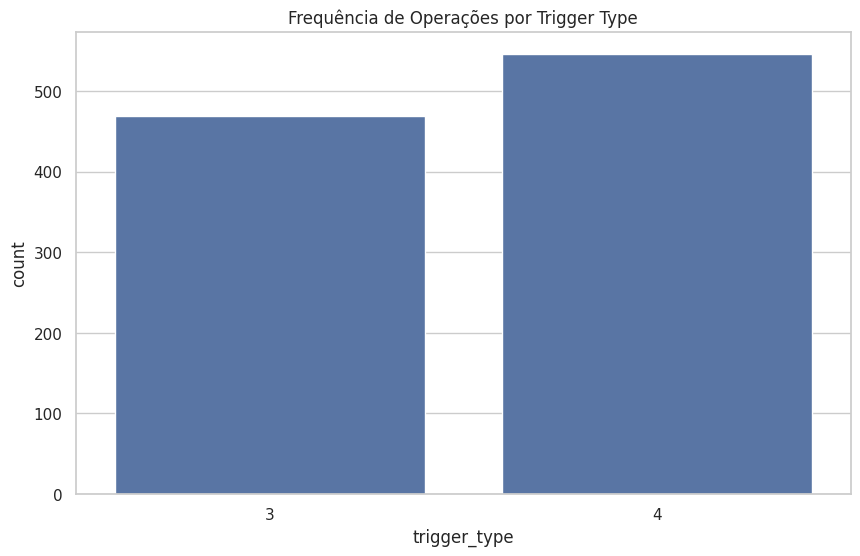


Relatório de Rentabilidade por Compra e Venda (Signal)
SIGNAL
-1    11.494094
 1    43.327416
Name: result, dtype: float64


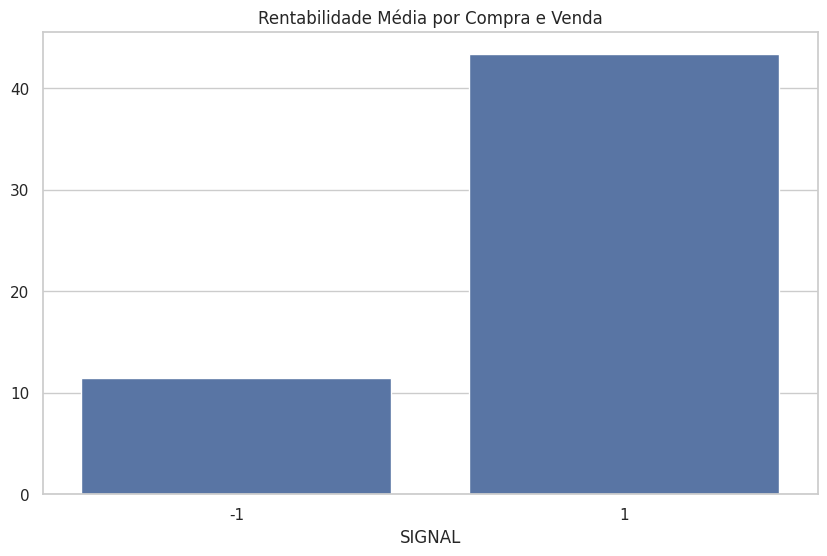


Análise de Resultados por Período
start_time
2023-01-26      0.0
2023-01-27      0.0
2023-01-30   -184.0
2023-01-31    184.0
2023-02-01   -207.0
              ...  
2024-09-09    -52.0
2024-09-10    -40.0
2024-09-11   -212.0
2024-09-18    -23.0
2024-09-19     63.0
Name: result, Length: 170, dtype: float64


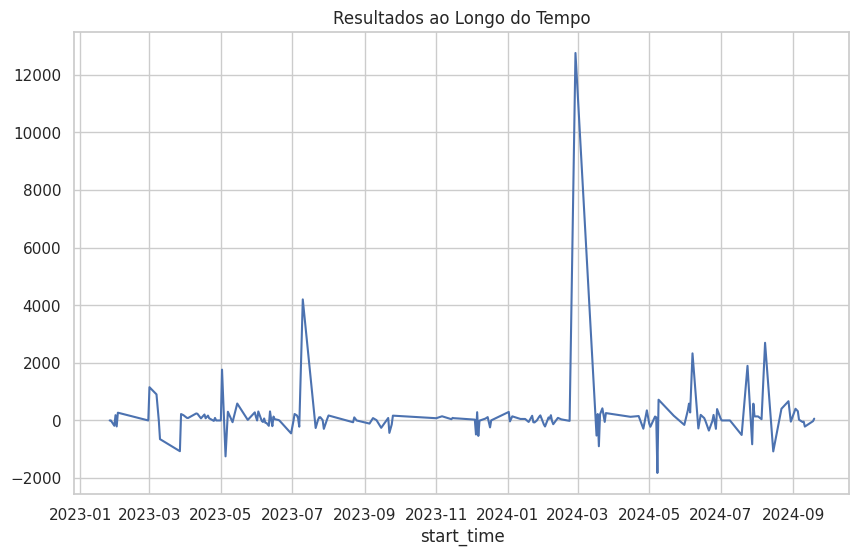


Diferença entre Preço de Entrada e Saída (Eficiência Operacional)


TypeError: unsupported operand type(s) for -: 'tuple' and 'float'

In [32]:
gerar_relatorios(df_results)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Função para calcular drawdown
def calcular_drawdown(df):
    """Calcula o maior drawdown, considerando o menor valor subsequente ao pico."""
    max_pico = df['accumulated_pips'].cummax()
    drawdown = max_pico - df['accumulated_pips']
    return drawdown.max()

# Função para calcular sequências de ganhos e perdas consecutivas
def calcular_sequencia_ganhos_perdas(df):
    """Calcula a quantidade de ganhos e perdas consecutivas."""
    df['result_positive'] = df['result'] > 0
    df['sequencia'] = (df['result_positive'] != df['result_positive'].shift(1)).cumsum()
    sequencias = df.groupby(['sequencia', 'result_positive']).size().reset_index(name='count')
    
    ganhos_consecutivos = sequencias[sequencias['result_positive'] == True]['count'].max()
    perdas_consecutivas = sequencias[sequencias['result_positive'] == False]['count'].max()
    
    return ganhos_consecutivos, perdas_consecutivas

# Função principal para gerar o relatório completo
def gerar_relatorio_completo(df):
    sns.set(style="whitegrid")
    
    # Formatação textual para o notebook
    def format_section(title):
        print("#" * 60)
        print(f"# {title}")
        print("#" * 60, "\n")
    
    format_section("1. Análise de Desempenho por Tipo de Fechamento (Trigger Type)")
    
    trigger_counts = df['trigger_type'].value_counts(normalize=True) * 100
    trigger_means = df.groupby('trigger_type')['result'].mean()
    trigger_durations = df.groupby('trigger_type')['count'].mean()
    
    print(f"Distribuição de operações por tipo de fechamento (em %):\n{trigger_counts}\n")
    print(f"Média de pips ganhos/perdidos por tipo de fechamento:\n{trigger_means}\n")
    print(f"Tempo médio (em candles) das operações por tipo de fechamento:\n{trigger_durations}\n")
    
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='trigger_type', palette='viridis')
    plt.title("Frequência de Operações por Tipo de Fechamento")
    plt.xlabel("Tipo de Fechamento")
    plt.ylabel("Número de Operações")
    plt.show()

    format_section("2. Análise de Rentabilidade por Compra e Venda (Signal)")
    
    signal_counts = df['SIGNAL'].value_counts(normalize=True) * 100
    signal_means = df.groupby('SIGNAL')['result'].mean()
    signal_durations = df.groupby('SIGNAL')['count'].mean()

    print(f"Distribuição de operações de compra e venda (em %):\n{signal_counts}\n")
    print(f"Média de pips ganhos/perdidos em operações de compra (1) e venda (-1):\n{signal_means}\n")
    print(f"Tempo médio (em candles) das operações de compra e venda:\n{signal_durations}\n")

    plt.figure(figsize=(10, 6))
    sns.barplot(x=['Compra (1)', 'Venda (-1)'], y=signal_means.values, palette='viridis')
    plt.title("Rentabilidade Média por Compra e Venda")
    plt.xlabel("Operações")
    plt.ylabel("Média de Pips")
    plt.show()

    format_section("3. Rentabilidade por Compra e Venda com relação ao Tipo de Fechamento")
    
    for trigger in df['trigger_type'].unique():
        print(f"Trigger Type {trigger}:")
        group = df[df['trigger_type'] == trigger].groupby('SIGNAL')['result'].mean()
        print(f"  Compra (1): {group.get(1, 'N/A')}")
        print(f"  Venda (-1): {group.get(-1, 'N/A')}")
        print()

    format_section("4. Tempo médio de operação e impacto nos resultados")
    
    signal_trigger_durations = df.groupby(['SIGNAL', 'trigger_type'])['count'].mean()
    print(f"Tempo médio de operação por tipo de fechamento e compra/venda:\n{signal_trigger_durations}\n")

    format_section("5. Análise de Volatilidade e Duração das Operações (Count)")
    
    count_result_corr = df[['count', 'result']].corr().iloc[0, 1]
    print(f"Correlação entre a duração das operações (candles) e o resultado: {count_result_corr}\n")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='count', y='result', hue='trigger_type', palette='coolwarm')
    plt.title("Duração das Operações (Candles) vs. Resultado (Pips)")
    plt.xlabel("Duração (Candles)")
    plt.ylabel("Resultado (Pips)")
    plt.show()

    format_section("6. Análise de Fechamento por Perdas Acumuladas (Trigger Type 3)")
    
    acum_loss_df = df[df['trigger_type'] == 3]
    if not acum_loss_df.empty:
        print(f"Frequência de operações com perdas acumuladas: {len(acum_loss_df)}")
        print(f"Lucro médio recuperado (2x perda): {acum_loss_df['result'].mean()}")
        print(f"Tempo médio de recuperação (em candles): {acum_loss_df['count'].mean()}\n")
    else:
        print("Nenhuma operação de perdas acumuladas encontrada.\n")
    
    format_section("7. Análise de Eficiência do Cruzamento Reverso (Trigger Type 4)")
    
    rev_cross_df = df[df['trigger_type'] == 4]
    if not rev_cross_df.empty:
        print(f"Frequência de operações com cruzamento reverso: {len(rev_cross_df)}")
        print(f"Lucro médio em cruzamentos reversos: {rev_cross_df['result'].mean()}")
        print(f"Tempo médio até cruzamento reverso (em candles): {rev_cross_df['count'].mean()}\n")
    else:
        print("Nenhuma operação de cruzamento reverso encontrada.\n")

    format_section("8. Análise de Drawdown e Recuperação")
    
    df['accumulated_pips'] = df['result'].cumsum()
    max_drawdown = calcular_drawdown(df)
    print(f"Maior drawdown subsequente: {max_drawdown} pips\n")
    
    format_section("9. Análise de Drawdown por Tipo de Fechamento")
    
    for trigger in df['trigger_type'].unique():
        print(f"Trigger Type {trigger}:")
        trigger_df = df[df['trigger_type'] == trigger]
        if not trigger_df.empty:
            drawdown = calcular_drawdown(trigger_df)
            print(f"  Maior drawdown subsequente: {drawdown} pips")
        else:
            print(f"  Nenhuma operação para Trigger Type {trigger}")
        print()

    format_section("10. KPIs Principais")
    
    total_operations = len(df)
    winning_operations = len(df[df['result'] > 0])
    losing_operations = len(df[df['result'] < 0])
    success_rate = (winning_operations / total_operations) * 100
    profit_factor = df[df['result'] > 0]['result'].sum() / abs(df[df['result'] < 0]['result'].sum())
    
    ganhos_consecutivos, perdas_consecutivas = calcular_sequencia_ganhos_perdas(df)

    print(f"Taxa de sucesso: {success_rate:.2f}%")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Maior sequência de ganhos consecutivos: {ganhos_consecutivos}")
    print(f"Maior sequência de perdas consecutivas: {perdas_consecutivas}\n")
    
    format_section("11. Quantidade de Operações com Lucro e Perda")
    
    # Operações com lucro e perda no geral
    total_lucro = len(df[df['result'] > 0])
    total_perda = len(df[df['result'] < 0])
    
    print(f"Total de Operações com Lucro: {total_lucro}")
    print(f"Total de Operações com Perda: {total_perda}\n")
    
    # Por tipo de operação (Compra e Venda)
    print("Por Compra e Venda:")
    for signal in df['SIGNAL'].unique():
        lucro = len(df[(df['SIGNAL'] == signal) & (df['result'] > 0)])
        perda = len(df[(df['SIGNAL'] == signal) & (df['result'] < 0)])
        operacao = "Compra (1)" if signal == 1 else "Venda (-1)"
        print(f"{operacao}:")
        print(f"  Operações com Lucro: {lucro}")
        print(f"  Operações com Perda: {perda}\n")
    
    # Por tipo de fechamento (Trigger Type)
    print("Por Tipo de Fechamento:")
    for trigger in df['trigger_type'].unique():
        lucro = len(df[(df['trigger_type'] == trigger) & (df['result'] > 0)])
        perda = len(df[(df['trigger_type'] == trigger) & (df['result'] < 0)])
        print(f"Trigger Type {trigger}:")
        print(f"  Operações com Lucro: {lucro}")
        print(f"  Operações com Perda: {perda}\n")

    format_section("12. Valor Total de Retorno (Result) por Tipo de Retorno")

    # Valor total de retorno geral
    total_retorno = df['result'].sum()
    print(f"Valor total de retorno geral: {total_retorno} pips\n")

    # Valor total de retorno por tipo de operação (Compra e Venda)
    print("Valor total de retorno por Compra e Venda:")
    for signal in df['SIGNAL'].unique():
        total_retorno_signal = df[df['SIGNAL'] == signal]['result'].sum()
        operacao = "Compra (1)" if signal == 1 else "Venda (-1)"
        print(f"{operacao}: {total_retorno_signal} pips\n")

    # Valor total de retorno por tipo de fechamento (Trigger Type)
    print("Valor total de retorno por Tipo de Fechamento:")
    for trigger in df['trigger_type'].unique():
        total_retorno_trigger = df[df['trigger_type'] == trigger]['result'].sum()
        print(f"Trigger Type {trigger}: {total_retorno_trigger} pips\n")

    format_section("13. Retorno Positivo e Negativo por Tipo de Retorno")

    # Retorno positivo e negativo por tipo de operação (Compra e Venda)
    print("Retorno Positivo e Negativo por Compra e Venda:")
    for signal in df['SIGNAL'].unique():
        positivo = df[(df['SIGNAL'] == signal) & (df['result'] > 0)]['result'].sum()
        negativo = df[(df['SIGNAL'] == signal) & (df['result'] < 0)]['result'].sum()
        operacao = "Compra (1)" if signal == 1 else "Venda (-1)"
        print(f"{operacao}:")
        print(f"  Retorno Positivo: {positivo} pips")
        print(f"  Retorno Negativo: {negativo} pips\n")

    # Retorno positivo e negativo por tipo de fechamento (Trigger Type)
    print("Retorno Positivo e Negativo por Tipo de Fechamento:")
    for trigger in df['trigger_type'].unique():
        positivo = df[(df['trigger_type'] == trigger) & (df['result'] > 0)]['result'].sum()
        negativo = df[(df['trigger_type'] == trigger) & (df['result'] < 0)]['result'].sum()
        print(f"Trigger Type {trigger}:")
        print(f"  Retorno Positivo: {positivo} pips")
        print(f"  Retorno Negativo: {negativo} pips\n")

    format_section("14. Gráficos e Visualizações")
    
    # Distribuição de triggers
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='trigger_type', palette='coolwarm')
    plt.title("Distribuição de Fechamentos por Tipo de Trigger")
    plt.show()
    
    # Saldo acumulado de pips ao longo do tempo
    plt.figure(figsize=(10, 6))
    df.plot(x='start_time', y='accumulated_pips', kind='line', title="Saldo Acumulado de Pips ao Longo do Tempo")
    plt.show()

# Exemplo de uso:
# df = pd.read_csv('seu_arquivo.csv')  # Ajustar o caminho do arquivo conforme necessário
# gerar_relatorio_completo(df)


############################################################
# 1. Análise de Desempenho por Tipo de Fechamento (Trigger Type)
############################################################ 

Distribuição de operações por tipo de fechamento (em %):
trigger_type
4    53.793103
3    46.206897
Name: proportion, dtype: float64

Média de pips ganhos/perdidos por tipo de fechamento:
trigger_type
3    117.296375
4    -49.827839
Name: result, dtype: float64

Tempo médio (em candles) das operações por tipo de fechamento:
trigger_type
3     15.656716
4    158.001832
Name: count, dtype: float64



/tmp/ipykernel_20554/4162239757.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




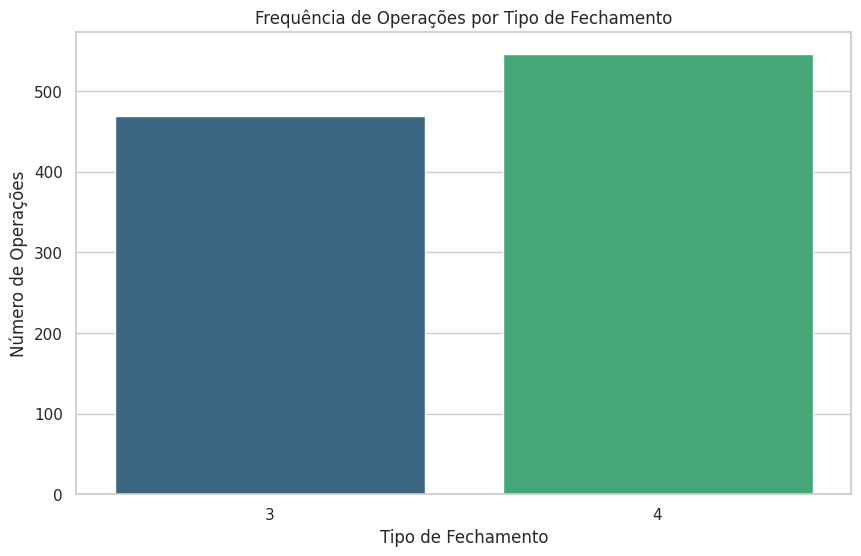

############################################################
# 2. Análise de Rentabilidade por Compra e Venda (Signal)
############################################################ 

Distribuição de operações de compra e venda (em %):
SIGNAL
-1    50.049261
 1    49.950739
Name: proportion, dtype: float64

Média de pips ganhos/perdidos em operações de compra (1) e venda (-1):
SIGNAL
-1    11.494094
 1    43.327416
Name: result, dtype: float64

Tempo médio (em candles) das operações de compra e venda:
SIGNAL
-1     59.265748
 1    125.256410
Name: count, dtype: float64



/tmp/ipykernel_20554/4162239757.py:62: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




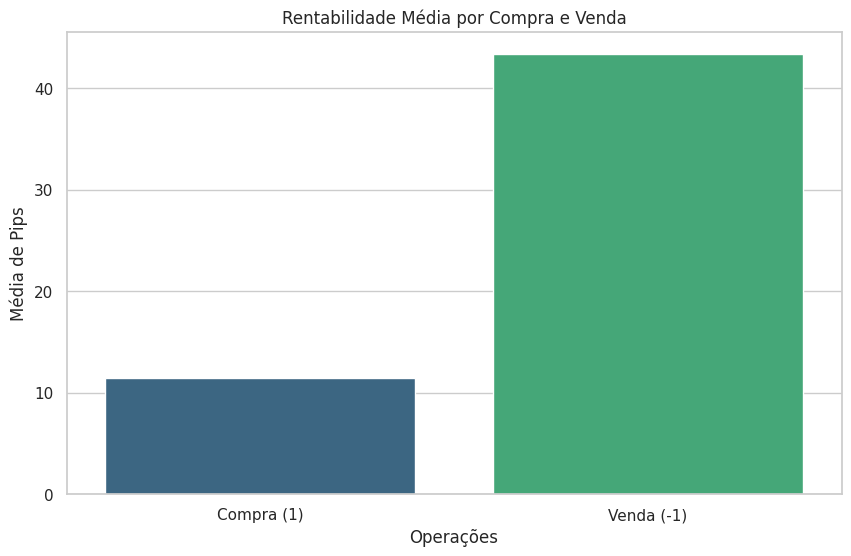

############################################################
# 3. Rentabilidade por Compra e Venda com relação ao Tipo de Fechamento
############################################################ 

Trigger Type 4:
  Compra (1): -19.919413919413564
  Venda (-1): -79.73626373626445

Trigger Type 3:
  Compra (1): 117.1153846153862
  Venda (-1): 117.47659574467977

############################################################
# 4. Tempo médio de operação e impacto nos resultados
############################################################ 

Tempo médio de operação por tipo de fechamento e compra/venda:
SIGNAL  trigger_type
-1      3                14.017021
        4                98.216117
 1      3                17.303419
        4               217.787546
Name: count, dtype: float64

############################################################
# 5. Análise de Volatilidade e Duração das Operações (Count)
############################################################ 

Correlação entre a dur

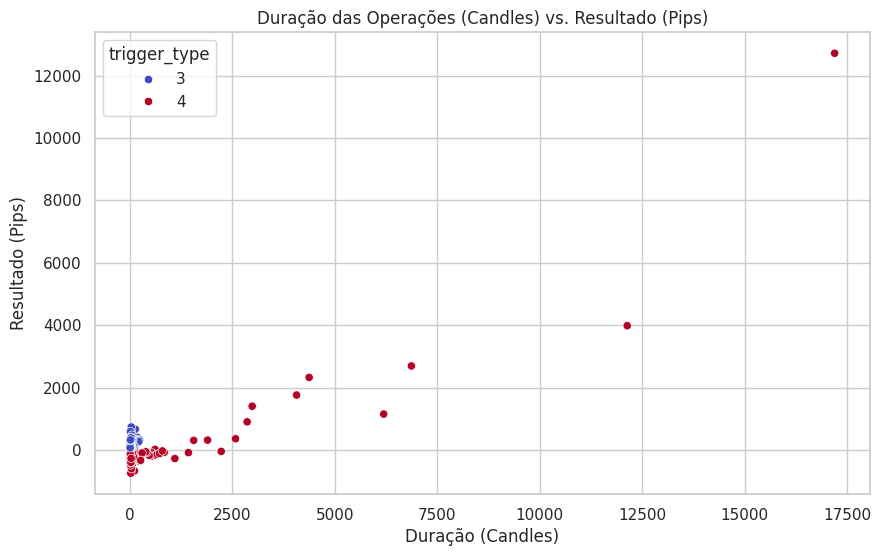

############################################################
# 6. Análise de Fechamento por Perdas Acumuladas (Trigger Type 3)
############################################################ 

Frequência de operações com perdas acumuladas: 469
Lucro médio recuperado (2x perda): 117.29637526652479
Tempo médio de recuperação (em candles): 15.656716417910447

############################################################
# 7. Análise de Eficiência do Cruzamento Reverso (Trigger Type 4)
############################################################ 

Frequência de operações com cruzamento reverso: 546
Lucro médio em cruzamentos reversos: -49.827838827839
Tempo médio até cruzamento reverso (em candles): 158.0018315018315

############################################################
# 8. Análise de Drawdown e Recuperação
############################################################ 

Maior drawdown subsequente: 2242.9999999999673 pips

############################################################
# 9

/tmp/ipykernel_20554/4162239757.py:219: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




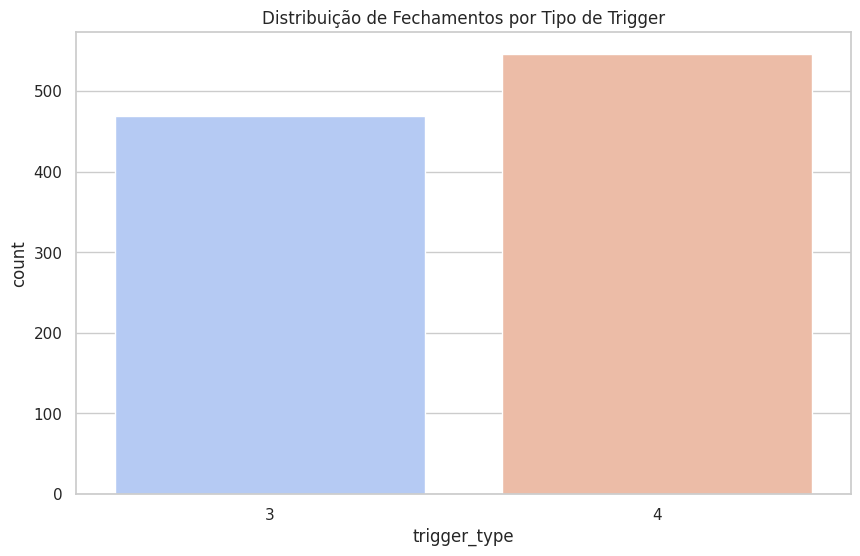

<Figure size 1000x600 with 0 Axes>

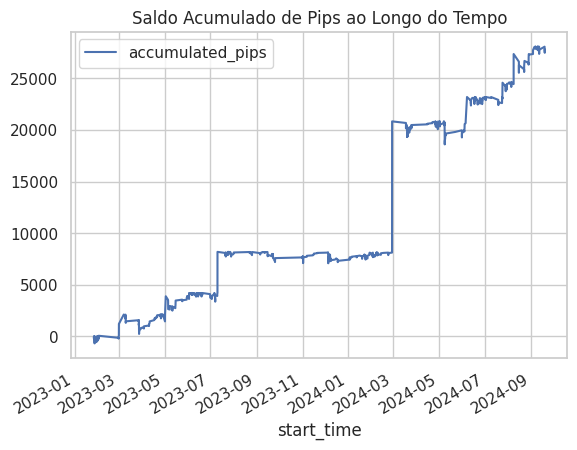

In [34]:
gerar_relatorio_completo(df_results)